In [1]:
using CairoMakie
using CSV
using DataFrames
using MLJ
using MLJBase

In [2]:
# Import training dataset
lichen_training = CSV.read("C:/Users/julio/Downloads/lichen_training.csv", DataFrame, missingstring="NA") |>
x -> DataFrames.select(x, "Total.lichen", "basal_area", "PL", "mean_Long", "mean_Lat", "Aspect_south", "SNR", "SMR", "SX") |>
x -> rename(x, ["biomass", "basalarea", "pl", "lon", "lat", "south", "snr", "smr", "sx"]) |>
dropmissing |>
x -> coerce(x, :pl=>Continuous, :sx=>Continuous, :snr=>Multiclass, :smr=>Multiclass);

In [3]:
# schema 
schema(lichen_training)

┌───────────┬───────────────────────────────────┬───────────────┐
│ _.names   │ _.types                           │ _.scitypes    │
├───────────┼───────────────────────────────────┼───────────────┤
│ biomass   │ Float64                           │ Continuous    │
│ basalarea │ Float64                           │ Continuous    │
│ pl        │ Float64                           │ Continuous    │
│ lon       │ Float64                           │ Continuous    │
│ lat       │ Float64                           │ Continuous    │
│ south     │ Float64                           │ Continuous    │
│ snr       │ CategoricalValue{String1, UInt32} │ Multiclass{3} │
│ smr       │ CategoricalValue{Int64, UInt32}   │ Multiclass{5} │
│ sx        │ Float64                           │ Continuous    │
└───────────┴───────────────────────────────────┴───────────────┘
_.nrows = 77


In [4]:
# Split predictors/responde variable
y, X = unpack(lichen_training, ==(:biomass), _->true; rng=1010)

# Split into train/test datasets
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=1010);

In [5]:
# Load a model and create a pipeline
model = @load RandomForestRegressor pkg=DecisionTree verbosity=0
pipe = @pipeline Standardizer OneHotEncoder model target=v->log.(v) inverse=v->exp.(v)

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\composition\models\pipelines.jl:372


Pipeline281(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    one_hot_encoder = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    random_forest_regressor = RandomForestRegressor(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 10,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0,
            rng = Random._GLOBAL_RNG()),
    target = WrappedFunction(
            f = var"#11#12"()),
    inverse = WrappedFunction(
            f = var"#13#14"()))

In [8]:
# Model tunning
r = [
     range(pipe, :(random_forest_regressor.max_depth), lower=1, upper=5),
     range(pipe, :(random_forest_regressor.n_trees), lower=10, upper=20)
]

tuned_model = TunedModel(
     model=pipe,
     tuning=Grid(resolution=20),
     resampling=CV(),
     range=r,
     measures=mae,
     train_best=true
)

m = machine(tuned_model, X, y)


┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Attempting to evaluate 55 models.
└ @ MLJTuning C:\Users\julio\.julia\packages\MLJTuning\bjRHJ\src\tuned_models.jl:680
┌ Error: Problem fitting the machine Machine{Resampler{CV},…}. 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:533
┌ Info: Running type checks... 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:539
┌ Info: Type checks okay. 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:542
┌ Error: Problem fitting the machine Machine{DeterministicTunedModel{Grid,…},…}. 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:533
┌ Info: Running type checks... 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:539
┌ Info: Type checks okay. 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:542


Machine{DeterministicTunedModel{Grid,…},…} trained 0 times; caches data
  args: 
    1:	Source @178 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{Multiclass{5}}}}`
    2:	Source @319 ⏎ `AbstractVector{Continuous}`


In [9]:
fit!(m, rows=train);

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Attempting to evaluate 55 models.
└ @ MLJTuning C:\Users\julio\.julia\packages\MLJTuning\bjRHJ\src\tuned_models.jl:680
Evaluating over 55 metamodels:   4%[>                        ]  ETA: 0:11:53

Evaluating over 55 metamodels:  53%[=============>           ]  ETA: 0:00:26

Evaluating over 55 metamodels:  55%[=============>           ]  ETA: 0:00:24

Evaluating over 55 metamodels:  56%[==============>          ]  ETA: 0:00:22

Evaluating over 55 metamodels:  58%[==============>          ]  ETA: 0:00:21

Evaluating over 55 metamodels:  60%[===============>         ]  ETA: 0:00:19

Evaluating over 55 metamodels:  62%[===============>         ]  ETA: 0:00:18

Evaluating over 55 metamodels:  64%[===============>         ]  ETA: 0:00:16

Evaluating over 55 metamodels:  65%[================>        ]  ETA: 0:00:15

Evaluating over 55 metamodels:  67%[================>        ]  ETA: 0:00:14

Evaluating over 55 metamodels:  69%[=================>       ]  ETA: 0:00:13

Evaluating over 55 metamodels:  71%[=================>       ]  ETA: 0:00:12

Evaluating over 55 metamodels:  73%[==================>      ]  ETA: 0:00:11

Evaluating over 55 metamodels:  75%[==================>      ]  ETA: 0:00:10

Evaluating over 55 metamodels:  76%[===================>     ]  ETA: 0:00:09

Evaluating over 55 metamodels:  78%[===================>     ]  ETA: 0:00:08

Evaluating over 55 metamodels:  80%[====================>    ]  ETA: 0:00:07

Evaluating over 55 metamodels:  82%[====================>    ]  ETA: 0:00:06

Evaluating over 55 metamodels:  84%[====================>    ]  ETA: 0:00:06

Evaluating over 55 metamodels:  85%[=====================>   ]  ETA: 0:00:05

Evaluating over 55 metamodels:  87%[=====================>   ]  ETA: 0:00:04

Evaluating over 55 metamodels:  89%[======================>  ]  ETA: 0:00:04

Evaluating over 55 metamodels:  91%[======================>  ]  ETA: 0:00:03

Evaluating over 55 metamodels:  93%[=======================> ]  ETA: 0:00:02

Evaluating over 55 metamodels:  95%[=======================> ]  ETA: 0:00:02

Evaluating over 55 metamodels:  96%[========================>]  ETA: 0:00:01

Evaluating over 55 metamodels:  98%[========================>]  ETA: 0:00:01

Evaluating over 55 metamodels: 100%[=========================] Time: 0:00:29


In [10]:
# Check fitted parameters
fp = fitted_params(m)

(best_model = Pipeline281,
 best_fitted_params = (inverse = (fitresult = nothing,),
                       random_forest_regressor = (forest = Ensemble of Decision Trees
Trees:      19
Avg Leaves: 16.789473684210527
Avg Depth:  5.0,),
                       one_hot_encoder = (fitresult = OneHotEncoderResult,),
                       standardizer = Dict(:basalarea => (19.488518518518518, 9.427699734935528), :sx => (9.74074074074074, 24.10369515646237), :lat => (55.90763463888889, 0.5439431472868074), :pl => (57.0, 43.93348316940311), :south => (0.7064814814814816, 0.20270954597145266), :lon => (-125.2643763888889, 0.855948240752152)),
                       target = (fitresult = nothing,),
                       machines = Machine[Machine{WrappedFunction,…}, Machine{Standardizer,…}, Machine{OneHotEncoder,…}, Machine{RandomForestRegressor,…}, Machine{WrappedFunction,…}],
                       fitted_params_given_machine = LittleDict{Any, Any, Vector{Any}, Vector{Any}}(Machine{WrappedFun

In [11]:
m.report.best_history_entry

(model = Pipeline281,
 measure = [MeanAbsoluteError()],
 measurement = [476.13518987741094],
 per_fold = [[307.8196616368084, 1402.7655965976057, 112.62393928393242, 289.3609250860561, 326.1948276071842, 418.04618905287805]],)

In [12]:
m.report.best_model

Pipeline281(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    one_hot_encoder = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    random_forest_regressor = RandomForestRegressor(
            max_depth = 5,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 19,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0,
            rng = Random._GLOBAL_RNG()),
    target = WrappedFunction(
            f = var"#11#12"()),
    inverse = WrappedFunction(
            f = var"#13#14"()))

In [13]:
m.report.plotting

(parameter_names = ["random_forest_regressor.max_depth", "random_forest_regressor.n_trees"],
 parameter_scales = [:linear, :linear],
 parameter_values = Any[2 13; 2 15; … ; 1 12; 3 14],
 measurements = [514.710202787897, 515.8474797842115, 535.7437779154736, 524.9499527632807, 512.2575013893864, 487.23634532202226, 499.93932549235234, 524.4561936610952, 507.4320731887587, 521.470806583327  …  485.11684505593576, 520.2386318978017, 524.7235647834831, 510.70585522495986, 500.8699662234673, 505.98409313326994, 506.49901141238314, 523.2907667400304, 520.7553256859306, 506.2322495908033],)

In [14]:
ŷ = predict(m, rows=train);

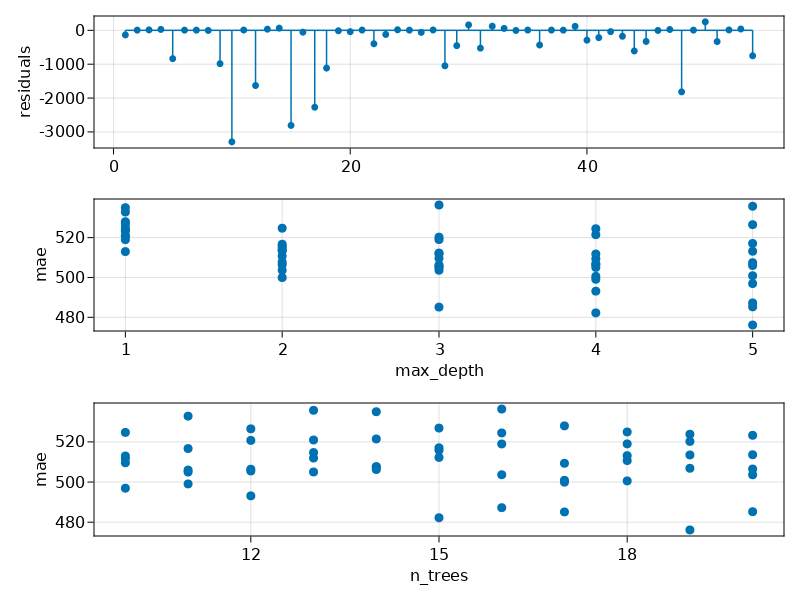

In [20]:
f = Figure()

ax1 = Axis(f[1, 1])
ax1.ylabel = "residuals"
stem!(ax1, ŷ - y[train])

ax2 = Axis(f[2, 1])
ax2.xlabel = "max_depth"
ax2.ylabel = "mae"
scatter!(ax2, Float64.(m.report.plotting.parameter_values[:, 1]), m.report.plotting.measurements)

ax3 = Axis(f[3, 1])
ax3.xlabel = "n_trees"
ax3.ylabel = "mae"
scatter!(ax3, Float64.(m.report.plotting.parameter_values[:, 2]), m.report.plotting.measurements)

f

In [16]:
# Make predictions on test and train subsets
ŷ_test = predict(m, rows=test)
ŷ_train = predict(m, rows=train);

In [17]:
@show mae(ŷ_test, y[test])
@show mae(ŷ_train, y[train]);

mae(ŷ_test, y[test]) = 763.4160680971996
mae(ŷ_train, y[train]) = 404.29489145664616


In [18]:
results = vcat(
    hcat(fill(1, length(ŷ_test)), ŷ_test),
    hcat(fill(2, length(y[test])), y[test])
)

46×2 Matrix{Float64}:
 1.0  1530.02
 1.0   165.325
 1.0   193.293
 1.0    18.5115
 1.0     9.09964
 1.0   205.667
 1.0   184.58
 1.0    33.8873
 1.0   203.088
 1.0   110.158
 ⋮    
 2.0   104.12
 2.0  3209.72
 2.0   254.57
 2.0  1274.84
 2.0   631.78
 2.0   455.89
 2.0   685.08
 2.0     1.87
 2.0   934.37

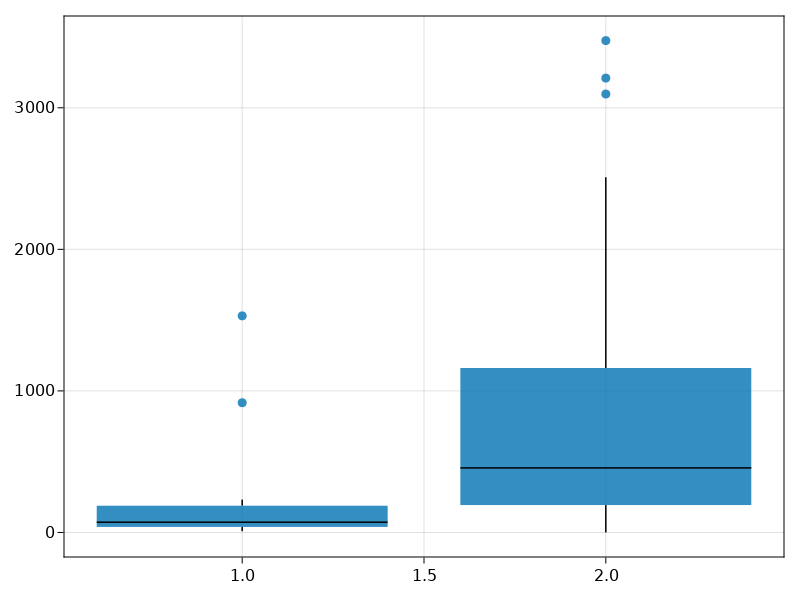

In [19]:
f = Figure()

ax1 = Axis(f[1, 1])
boxplot!(ax1, results[:, 1], results[:, 2])

f

# Predict on new dataset

In [ ]:
# Import CSV to dataframe, select the same columns used for training
lichen = CSV.read("C:/Users/jnovoa/Downloads/predicted_biomass_Nov2021.csv", DataFrame) |>
x -> select(x, :BASAL_AREA, :PL, :LON) |>
x -> rename(x, ["basalarea", "pl", "lon"]);

In [ ]:
# Predict on a new dataset
biomass = exp.(predict(m, lichen))

In [ ]:
# Combine new dataset with predictions
results = hcat(lichen, biomass)

In [ ]:
# Export results to CSV
CSV.write("C:/Users/julio/Downloads/predicted_biomass_rf.csv", results)